In [20]:
import logging
import os
import sys
from pathlib import Path
from random_word import RandomWords


import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import pandas as pd

# Add the parent directory to sys.path
sys.path.append(os.path.dirname(os.path.realpath(os.path.abspath(""))))

from unet.dataset import DeadwoodDataset
from unet.dice_score import dice_loss
from unet.evaluate import evaluate
from unet.unet_model import UNet

In [19]:
import importlib

importlib.reload(sys.modules["unet.dataset"])

<module 'unet.dataset' from '/net/home/jmoehring/standing-deadwood/unet/dataset.py'>

In [2]:
# data paths
register_file = "/net/scratch/jmoehring/tiles_register_biome_bin.csv"
checkpoint_dir = "/net/scratch/jmoehring/checkpoints"

# data params
test_size: float = 0.3
no_folds: int = 5
random_seed: int = 42
batch_size: int = 24
save_checkpoint: bool = True
samples_per_res: int = 0  # means all samples

# model params
epochs: int = 10
learning_rate: float = 1e-5
amp: bool = False
weight_decay: float = 1e-8
momentum: float = 0.999
gradient_clipping: float = 1.0

In [3]:
register_df = pd.read_csv(register_file)

In [4]:
register_df.head()

,base_file_name,file_path,resolution,x,y,label_quality,biome,resolution_bin
0,uavforsat_2017_CFB141_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.14,577,342,3.0,4.0,0.14
1,uavforsat_2017_CFB141_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.14,374,545,3.0,4.0,0.14
2,uavforsat_2017_CFB141_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.14,374,342,3.0,4.0,0.14
3,uavforsat_2017_CFB141_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.14,577,545,3.0,4.0,0.14
4,uavforsat_2017_CFB141_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.20,250,228,3.0,4.0,0.20


In [21]:
dataset = DeadwoodDataset(
    register_df=register_df,
    test_size=test_size,
    random_seed=random_seed,
)

<Axes: >

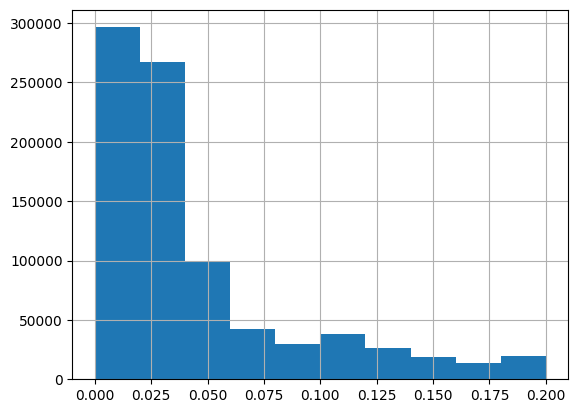

In [29]:
dataset.train_register_df["resolution_bin"].hist()

<Axes: >

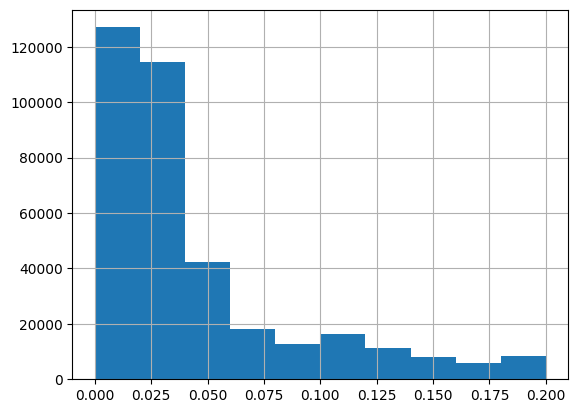

In [30]:
dataset.test_register_df["resolution_bin"].hist()

In [4]:
def initialize_experiment(run_name: str):
    # initialize a new experiment run
    experiment = wandb.init(
        project="standing-deadwood-unet",
        resume="allow",
        name=run_name,
    )
    experiment.config.update(
        dict(
            data=dict(
                test_size=test_size,
                random_seed=random_seed,
                batch_size=batch_size,
                save_checkpoint=save_checkpoint,
            ),
            model=dict(
                epochs=epochs,
                learning_rate=learning_rate,
                amp=amp,
                weight_decay=weight_decay,
                momentum=momentum,
                gradient_clipping=gradient_clipping,
            ),
        )
    )
    return experiment

In [5]:
loader_args = {
    "batch_size": batch_size,
    "num_workers": 12,
    "pin_memory": True,
    "shuffle": True,
}

In [ ]:
r = RandomWords()
run_identifier = f"{r.get_random_word()}-{r.get_random_word()}-{r.get_random_word()}"

run_name = f"deadwood_{run_identifier}"
experiment = initialize_experiment(0, run_name)

# preferably use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model with three input channels (RGB)
model = UNet(n_channels=3, n_classes=1, bilinear=True)
model = model.to(memory_format=torch.channels_last)
model.to(device=device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# loss function (binary cross entropy)
criterion = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    momentum=momentum,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max", patience=5)
grad_scaler = torch.cuda.amp.grad_scaler.GradScaler(enabled=amp)

wandb.watch(model, log="all")

In [ ]:
train_set, val_set = dataset.get_train_test()

In [6]:
step = 0
for epoch in range(1, epochs + 1):
    train_loader = DataLoader(train_set, **loader_args)
    val_loader = DataLoader(val_set, **loader_args)

    model.train()
    epoch_loss = 0

    with tqdm(
        total=len(train_loader), desc=f"Epoch {epoch}/{epochs}", unit="img"
    ) as pbar:
        for batch, (images, masks_true) in enumerate(train_loader):
            images = images.to(
                device=device,
                dtype=torch.float32,
                memory_format=torch.channels_last,
            )
            masks_true = masks_true.to(device=device, dtype=torch.long).squeeze(1)

            with torch.amp.autocast(
                device.type if device.type != "mps" else "cpu", enabled=amp
            ):
                masks_pred = model(images).squeeze(1)

                loss = criterion(masks_pred.squeeze(1), masks_true.float())
                loss += dice_loss(
                    F.sigmoid(masks_pred.squeeze(1)),
                    masks_true.float(),
                )
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad.clip_grad_norm_(
                    model.parameters(), gradient_clipping
                )
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                epoch_loss += loss.item()
                step += 1

    val_dice_score, val_dice_loss = evaluate(model, criterion, val_loader, device, amp)
    experiment.log(
        {
            "train loss": epoch_loss / len(train_loader),
            "val loss": val_dice_loss,
            "val dice score": val_dice_score,
            "epoch": epoch,
        }
    )
    if save_checkpoint:
        Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
        state_dict = model.state_dict()
        torch.save(
            state_dict,
            os.path.join(checkpoint_dir, f"{run_name}_epoch_{epoch}.pth"),
        )
        logging.info(f"Checkpoint {epoch} saved!")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jmoehring. Use `wandb login --relogin` to force relogin


Epoch 1/10:   0%|          | 0/2750 [00:01<?, ?img/s]


ValueError: too many values to unpack (expected 2)